# 🛠️ Instalación de dependencias (versiones compatibles)

⚠️ IMPORTANTE:
Es obligatorio instalar estas versiones específicas de las librerías para garantizar la compatibilidad entre ellas. Usar versiones diferentes puede provocar errores durante la ejecución.

In [1]:
!pip install -q --upgrade pip
!pip install numpy==1.23.5
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 -f https://download.pytorch.org/whl/cu121
!pip install monai==1.4.0 torchio==0.20.2 vtk==9.3.0 nibabel==5.2.1

  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Looking in links: https://download.pytorch.org/whl/cu121


# 📦 Verificación de versiones instaladas
✅ Esta celda sirve para comprobar que las versiones de las librerías instaladas coinciden con las requeridas.

In [2]:
import torch
import torchio as tio
import vtk
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy

print("Torch version:", torch.__version__)
print("TorchIO version:", tio.__version__)
print("VTK version:", vtk.vtkVersion().GetVTKVersion())

Torch version: 2.2.2+cu121
TorchIO version: 0.20.2
VTK version: 9.3.0


# 📂 Montaje de Google Drive y definición de rutas
🔗 En esta celda montamos Google Drive para acceder a los archivos necesarios del proyecto.
Se definen tres rutas principales que se usarán a lo largo del código:

*  **data_dir:** contiene las imágenes y máscaras (por ejemplo, Study.vtk y las máscaras por parte del corazón).
*  **models_dir:** carpeta donde se almacenan los modelos entrenados y sus gráficas de entrenamiento.

Asegúrate de que las carpetas existen en tu Drive antes de continuar.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/tfm_alvaro/data"
models_dir = "/content/drive/MyDrive/tfm_alvaro/models"

Mounted at /content/drive


🧩 Importación de librerías necesarias

In [4]:
import os
from vtk.util.numpy_support import vtk_to_numpy
import torch
from monai.networks.nets import UNet
import matplotlib.pyplot as plt

## 📥 Función: read_vtk_volume
Esta función carga un volumen en formato `.vtk` y lo convierte en un array de NumPy para su posterior procesamiento en Python.

In [5]:
def read_vtk_volume(path):
    # Crear un lector VTK para archivos de puntos estructurados
    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName(path)
    reader.Update()
    # Obtener la imagen como objeto VTK
    image = reader.GetOutput()
    # Obtener las dimensiones (X, Y, Z)
    dims = image.GetDimensions()
    # Extraer los valores escalares (intensidades de voxeles)
    scalars = vtk_to_numpy(image.GetPointData().GetScalars())
    # Reorganizar los datos a formato (Z, Y, X)
    volume = scalars.reshape(dims[::-1])
    return volume

# Preprocesamiento de los datos

Esta función prepara la imagen y la máscara para ser procesadas por la red neuronal:

- Normaliza los valores de la imagen entre 0 y 1.
- Añade una dimensión extra para representar el canal (requerido por PyTorch).
- Convierte ambos arrays (imagen y máscara) a tensores de PyTorch en formato `float32`.

Se utiliza justo antes de pasar los datos al modelo para asegurar que el formato sea correcto.


In [6]:
def preprocess_data(image_np, mask_np):
    # Normalizar intensidades de la imagen entre 0 y 1
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Añadir una dimensión al principio para representar el canal
    image_np = image_np[np.newaxis, ...]
    mask_np = mask_np[np.newaxis, ...]

    # Convertir los arrays de NumPy a tensores de PyTorch con tipo float32
    image_tensor = torch.tensor(image_np, dtype=torch.float32)
    mask_tensor = torch.tensor(mask_np, dtype=torch.float32)

    return image_tensor, mask_tensor

# Creación del DataLoader

Esta función transforma los tensores de imagen y máscara en un `Subject` de TorchIO, que es una estructura que permite trabajar con datos volumétricos médicos.

- Usa `ScalarImage` para la imagen (valores continuos).
- Usa `LabelMap` para la máscara (etiquetas discretas).
- Se crea un `SubjectsDataset` con un solo sujeto.
- Finalmente, se devuelve un `DataLoader` de PyTorch con `batch_size = 1`.

Este cargador de datos puede usarse para alimentar modelos durante la inferencia o entrenamiento.


In [7]:
def create_dataloader(image_tensor, mask_tensor):

    # Crear un sujeto con imagen y máscara, usando tipos de TorchIO apropiados
    subject = tio.Subject(
        image=tio.ScalarImage(tensor=image_tensor),  # Imagen con valores continuos
        mask=tio.LabelMap(tensor=mask_tensor),       # Máscara binaria o categórica
    )

    # Crear dataset a partir de una lista de sujetos
    dataset = tio.SubjectsDataset([subject])

    # Crear un DataLoader para iterar sobre el dataset
    loader = torch.utils.data.DataLoader(
      dataset, batch_size=1, collate_fn=tio.utils.collate
    )


    return loader

# Creación del modelo 3D UNet

Esta función crea e inicializa un modelo **3D UNet** diseñado para segmentación médica volumétrica.

- El modelo está configurado con 4 niveles de profundidad y unidades residuales.
- Utiliza un único canal de entrada (imágenes en escala de grises) y genera una salida binaria.
- La arquitectura se construye con `MONAI` y se mueve automáticamente al dispositivo indicado (`CPU` o `GPU`).

Este modelo se utilizará para predecir máscaras 3D de las estructuras del corazón.

In [8]:
def create_model(device):
    #Creamos el modelo con las configuraciones necesarias
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
    ).to(device)
    return model

# Entrenamiento del modelo 3D UNet

Esta función entrena el modelo **3D UNet** utilizando un `DataLoader` con los datos preprocesados.

- Se realiza una optimización estándar con backpropagation.
- En cada época, se calcula la pérdida promedio.
- Se usa una función de pérdida (`loss_fn`) y un optimizador (`optimizer`), como Adam o SGD.

Al final del entrenamiento, se devuelve una lista con los valores de pérdida por época, útil para graficar o evaluar la convergencia del modelo.

In [9]:
def train_model(model, loader, loss_fn, optimizer, epochs, device):
    losses = []              # Lista para almacenar la pérdida de cada época
    model.train()            # Establecer el modelo en modo entrenamiento

    # Bucle principal de entrenamiento por época
    for epoch in range(epochs):
        total_loss = 0       # Acumulador de pérdida para esta época

        # Iterar sobre el DataLoader
        for batch in loader:
            # Obtener imágenes y máscaras del batch y moverlas al dispositivo
            inputs = batch['image'][tio.DATA].to(device)
            targets = batch['mask'][tio.DATA].to(device)

            optimizer.zero_grad()             # Reiniciar gradientes
            outputs = model(inputs)           # Hacer predicción
            loss = loss_fn(outputs, targets)  # Calcular la pérdida
            loss.backward()                   # Propagación hacia atrás
            optimizer.step()                  # Actualizar pesos del modelo

            total_loss += loss.item()    # Acumular la pérdida

        # Calcular pérdida promedio de la época
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)

        # Imprimir progreso
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

    return losses

# 📉 Visualización de la Pérdida durante el Entrenamiento

Esta función genera una gráfica de la evolución de la pérdida (loss) durante el entrenamiento del modelo.

- Eje X: número de épocas.
- Eje Y: valor de la función de pérdida.
- La gráfica se guarda automáticamente en la ruta especificada (`output_path`).
- También se muestra en pantalla para visualización inmediata.

Es útil para evaluar la convergencia del modelo y detectar posibles problemas como overfitting.


In [10]:
def plot_losses(losses, output_path):
    plt.figure(figsize=(10, 5))  # Crear figura con tamaño personalizado

    # Dibujar la curva de pérdida
    plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
    plt.xlabel('Epoch')               # Etiqueta del eje X
    plt.ylabel('Loss')                # Etiqueta del eje Y
    plt.title('Training Loss Evolution')  # Título del gráfico
    plt.legend()                      # Mostrar leyenda
    plt.grid(True)                    # Mostrar rejilla

    # Guardar gráfico en el archivo especificado
    plt.savefig(output_path)

    # Mostrar el gráfico en pantalla
    plt.show()

    print(f'Loss curve saved at: {output_path}')  # Mensaje de confirmación


# 🧩 Configuración de las partes del corazón (`heart_parts`)

La lista `heart_parts` define qué estructuras cardíacas se van a ENTRENAR, cuántas épocas se entrenarán, y si deben ser activadas o no.

Cada elemento es una tupla con tres valores:

1. **Nombre** de la estructura (por ejemplo: `"LV"`).
2. **Valor entero** Número de épocas de entrenamiento.
3. **Booleano** (`True` o `False`) indicando si se va a procesar esa estructura o no.

In [11]:
heart_parts = [
    ("LV", 200, True),
    ("LV_Epi", 100, False),
    ("RV_Epi", 100, False),
    ("RV_Epi", 200, False),
    ("LV_Endo", 100, False),
    ("LV_Endo", 200, False),
    ("RV_Endo", 1200, False),
    ("RV_Endo", 200, False),
    ("Core_Surface", 1000, False),
    ("Border_Zone_Surface", 1000, False)
]

# 🚀 Entrenamiento por partes del corazón (`main`)

Este bloque de código entrena un modelo 3D UNet para cada una de las partes del corazón activadas en la lista `heart_parts`.

## 🔁 Flujo principal:

1. Recorre cada tupla de `heart_parts`.
2. Verifica si la parte está activada (`flag == True`).
3. Carga la imagen de estudio (`Study.vtk`) y la máscara correspondiente.
4. Preprocesa los datos y crea el `DataLoader`.
5. Inicializa el modelo 3D UNet.
6. Entrena el modelo por el número de épocas especificado (`epochs`).
7. Guarda el modelo entrenado y la curva de pérdida.


###################################################################
                         LV
###################################################################
Epoch 1/200 - Loss: 2.0963
Epoch 2/200 - Loss: 2.0438
Epoch 3/200 - Loss: 2.0070
Epoch 4/200 - Loss: 1.9822
Epoch 5/200 - Loss: 1.9628
Epoch 6/200 - Loss: 1.9478
Epoch 7/200 - Loss: 1.9357
Epoch 8/200 - Loss: 1.9254
Epoch 9/200 - Loss: 1.9171
Epoch 10/200 - Loss: 1.9100
Epoch 11/200 - Loss: 1.9039
Epoch 12/200 - Loss: 1.8986
Epoch 13/200 - Loss: 1.8940
Epoch 14/200 - Loss: 1.8899
Epoch 15/200 - Loss: 1.8861
Epoch 16/200 - Loss: 1.8828
Epoch 17/200 - Loss: 1.8794
Epoch 18/200 - Loss: 1.8765
Epoch 19/200 - Loss: 1.8737
Epoch 20/200 - Loss: 1.8709
Epoch 21/200 - Loss: 1.8684
Epoch 22/200 - Loss: 1.8658
Epoch 23/200 - Loss: 1.8633
Epoch 24/200 - Loss: 1.8608
Epoch 25/200 - Loss: 1.8582
Epoch 26/200 - Loss: 1.8558
Epoch 27/200 - Loss: 1.8532
Epoch 28/200 - Loss: 1.8506
Epoch 29/200 - Loss: 1.8479
Epoch 30/200 - Loss: 1.8450
Epoch

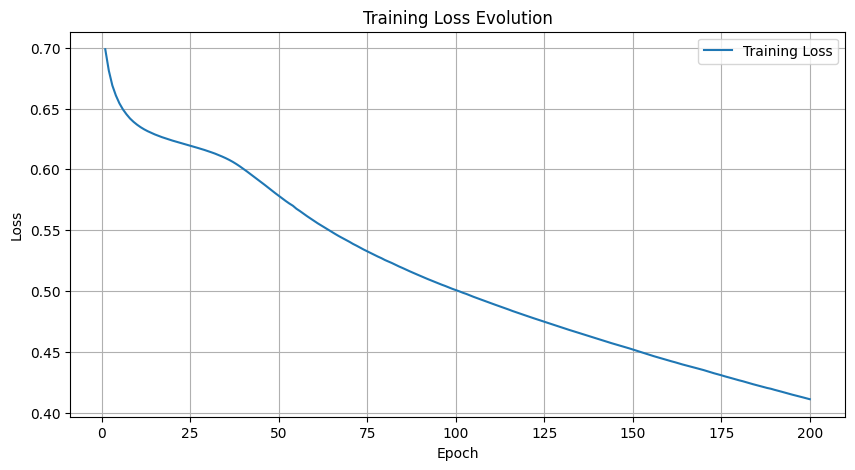

Loss curve saved at: /content/drive/MyDrive/tfm_alvaro/models/LV/loss_curve_LV.png


[INFO] Done!


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recorremos el diccionario de estructuras
for heart_part, epochs, flag in heart_parts:

    if not flag:
        continue

    print("###################################################################")
    print(f"                         {heart_part}")
    print("###################################################################")

    # Directorio para guardar modelos por estructura
    model_dir = os.path.join(models_dir, heart_part)
    os.makedirs(model_dir, exist_ok=True)

    # Lista para almacenar sujetos de distintos pacientes
    subjects = []

    # Recorrer todas las subcarpetas dentro de la carpeta BarraData
    for patient_folder in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_folder)

        if not os.path.isdir(patient_path):
            continue

        # Rutas a imagen y máscara del paciente actual
        image_path = os.path.join(patient_path, "Study.vtk")
        mask_path = os.path.join(patient_path, f"Mask_Image_{heart_part}.vtk")

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"[WARNING] Datos faltantes en {patient_folder}, omitiendo...")
            continue

        # Leer y procesar datos
        image_np = read_vtk_volume(image_path)
        mask_np = read_vtk_volume(mask_path)
        image_tensor, mask_tensor = preprocess_data(image_np, mask_np)

        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image_tensor),
            mask=tio.LabelMap(tensor=mask_tensor)
        )
        subjects.append(subject)

    # Si no hay datos válidos, continuar
    if len(subjects) == 0:
        print(f"[WARNING] No hay datos válidos para {heart_part}, saltando.")
        continue

    # Crear DataLoader con todos los pacientes
    dataset = tio.SubjectsDataset(subjects)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

    # Modelo y entrenamiento
    model = create_model(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    losses = train_model(model, loader, loss_fn, optimizer, epochs, device)

    # Guardar modelo y curva de pérdida
    model_path = os.path.join(model_dir, f"model_3dunet_{heart_part}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

    loss_plot_path = os.path.join(model_dir, f"loss_curve_{heart_part}.png")
    plot_losses(losses, loss_plot_path)

    print("\n")

print("[INFO] Done!")